# Preprocessing

### Imports and Dataloading

In [1]:
# imports
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import math
import datetime
import numpy as np

# load data
path = Path('data', 'weatherAUS.csv')
df = pd.read_csv(path)
variables = df.columns[:-1]
target_var = df.columns[-1]

### Inspect Unmodified Data


In [2]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


The dataframe consists of 23 columns, containing both numerial and categorical data.\
We can also see NaN-values in different columns.\
The target variable "RainTomorrow" is binary (i.e. categorical), allowing only Yes and No values. 


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

The numerical columns are MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm, Pressure9am, Pressure3pm, Cloud9am, Cloud3pm, Temp9am, and Temp3pm.

Categorical variables are Date, Location, WindGustDir, WindDir9am, WindDir3pm, and RainToday.

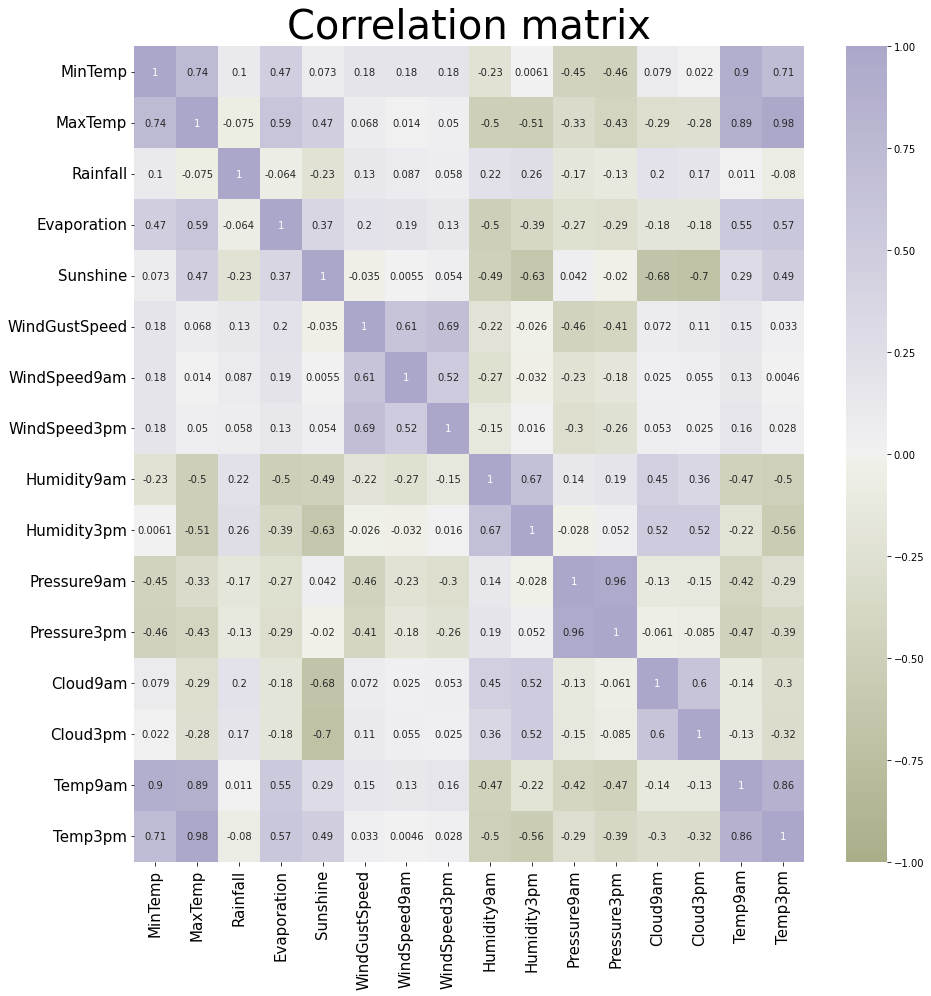

In [4]:
plt.figure(figsize= (15,15))
cmap = sns.diverging_palette(90, 270, s=35, l=70, n=8, as_cmap=True)
matrix = sns.heatmap(df.corr(), annot=True, vmin = -1, vmax = 1, center = 0, cmap=cmap)
matrix.axes.set_title('Correlation matrix', fontsize = 40)
matrix.tick_params(labelsize=15)

We can find notable correlations between some columns in the data:
* MinTemp, MaxTemp, Temp9am and Temp3pm: This is plausible, as all of those columns measure the temperature.
* WindGustSpeed, WindSpeed9am, Windspeed3pm: Also plausible, because all of those cover wind speed.
* In general, all sensor values that cover the same "unit" (like wind speed, pressure etc.) will have similar values.

One could consider cutting for example Humidity9am, if you already have Humdity3pm and those 2 correlate a lot anyways. But for now, we keep it as is.

### Preprocessing/Cleaning

The Preprocessing and Cleaning consists of the following steps:
1.  Remove all rows where the target variable is NaN (for obvious reasons).
2.  Remove all rows that have 4 or more NaN-values. We consider those rows to be too inaccurate and don't want to use those for training.\
3.  Fill NaN-values for categorical columns with the mode.
4.  Encode some categorical columns for which we can extract further knowledge.\
    4.1.    Encode "Date" into year and month.\
    4.2.    Encode "WindGustDir", "WindDir9am" and "WindDir3pm" into two columns that encode direction.
5.  Normalize numerical columns.
6.  Fill NaN-values for numerical columns with mean.
7.  Cap outlier values with the help of the z-score in numerical columns.
8.  Dummy Encode rest of the categorical columns (i.e. all except for "Date", "WindGustDir", "WindDir9am", "WindDir3pm").

In [5]:
# 1. Remove all rows where the target variable is NaN
df.dropna(subset=target_var, inplace=True)
assert(df[target_var].isna().sum() == 0)

# 2. Remove all rows that have 4 or more NaN-values.
df.dropna(thresh=len(df.columns)-4, inplace=True)

In [6]:
# 3. Fill NaN-values for categorical columns with the mode.
def get_cols_with_type(df: pd.DataFrame, categorical: bool):
    s = (df.dtypes == "object")
    if not categorical: s = ~s
    object_cols = list(s[s].index)
    return list(s[s].index)
    
cat_col = get_cols_with_type(df, categorical=True)

for col in cat_col:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [7]:
# 4.1 Encode "Date" into year and month
dates = pd.to_datetime(df.Date)
df.drop(['Date'], axis=1, inplace=True)
df.insert(0, 'Year', [date.year for date in dates])
df.insert(0, 'Month', [date.month for date in dates])

We consider the particular day of any particular measurement to be irrelevant for model performance, so we drop this information.

In [8]:
# 4.2 Encode "WindGustDir", "WindDir9am" and "WindDir3pm" into two columns that encode direction.
# convert WindDir features to numerical
def encode_direction(df, col_name):
    card_dir_to_WE = {
        'N': 0, 'NNE': 0.382683, 'NE': 1 / math.sqrt(2), 'ENE': 0.923880, 'E': 1, 'ESE': 0.923880, 'SE': 1 / math.sqrt(2), 'SSE': 0.382683, 
        'S': 0, 'SSW': -0.382683, 'SW': -1 / math.sqrt(2), 'WSW': -0.923880, 'W': -1, 'WNW': -0.923880, 'NW': -1 / math.sqrt(2), 'NNW': -0.382683
    }
    card_dir_to_NS = {
        'W': 0, 'WNW': 0.382683, 'NW': 1 / math.sqrt(2), 'NNW': 0.923880, 'N': 1, 'NNE': 0.923880, 'NE': 1 / math.sqrt(2), 'ENE': 0.382683, 
        'E': 0, 'ESE': -0.382683, 'SE': -1 / math.sqrt(2), 'SSE': -0.923880, 'S': -1, 'SSW': -0.923880, 'SW': -1 / math.sqrt(2), 'WSW': -0.382683
    }

    vals = df[col_name]
    col_pos = df.columns.get_loc(col_name)
    df.drop([col_name], axis=1, inplace=True)
    df.insert(col_pos, f"{col_name}_WE", [card_dir_to_WE[num_v] for num_v in vals])
    df.insert(col_pos, f"{col_name}_NS", [card_dir_to_NS[num_v] for num_v in vals])
    
encode_direction(df, 'WindGustDir')
encode_direction(df, 'WindDir9am')
encode_direction(df, 'WindDir3pm')

In [9]:
# 5. Normalize numerical columns
num_cols = get_cols_with_type(df, categorical=False)
df[num_cols] = (df[num_cols] - df[num_cols].mean()) / (df[num_cols].std())
df.describe()

,Month,Year,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir_NS,WindGustDir_WE,WindGustSpeed,...,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,1.233690e+05,1.233690e+05,1.232910e+05,1.233360e+05,1.229340e+05,8.028600e+04,7.380900e+04,1.233690e+05,1.233690e+05,1.191540e+05,...,1.233060e+05,1.233370e+05,1.229480e+05,1.223680e+05,1.227270e+05,1.227770e+05,8.442800e+04,8.237000e+04,1.232810e+05,1.227330e+05
mean,1.393797e-16,-7.549081e-15,5.163769e-17,-9.217652e-17,-5.294362e-17,-1.189459e-16,-2.587677e-16,-2.359952e-17,1.336202e-17,-5.504062e-17,...,5.485838e-17,-1.129153e-16,-1.497972e-16,5.388530e-17,-2.073541e-14,-8.944793e-15,3.501040e-17,6.409290e-17,7.654065e-17,3.204977e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.573259e+00,-2.252076e+00,-3.300633e+00,-2.995321e+00,-2.768327e-01,-1.319529e+00,-2.018305e+00,-1.378623e+00,-1.318853e+00,-2.493775e+00,...,-1.693969e+00,-2.222868e+00,-3.598169e+00,-2.472824e+00,-5.238034e+00,-5.431603e+00,-1.538651e+00,-1.656307e+00,-3.194878e+00,-2.976892e+00
25%,-9.922091e-01,-1.070161e+00,-7.249773e-01,-7.746148e-01,-2.768327e-01,-6.917432e-01,-7.221402e-01,-9.522919e-01,-9.138898e-01,-7.020085e-01,...,-6.519911e-01,-7.208383e-01,-6.376616e-01,-7.356539e-01,-6.572382e-01,-6.799067e-01,-1.191726e+00,-9.208611e-01,-7.534889e-01,-7.551361e-01
50%,-1.206336e-01,1.117545e-01,-4.131556e-02,-8.691233e-02,-2.768327e-01,-1.605398e-01,2.301442e-01,7.696261e-02,6.377729e-02,-1.047530e-01,...,-1.888896e-01,-2.759405e-02,4.959916e-02,3.642174e-02,-6.878299e-03,-9.246942e-03,1.959720e-01,1.823079e-01,-6.489197e-02,-9.302343e-02
75%,7.509420e-01,8.996982e-01,7.218418e-01,7.154072e-01,-1.832689e-01,4.672461e-01,7.856435e-01,1.106217e+00,1.041444e+00,5.671594e-01,...,6.215379e-01,5.501095e-01,7.368599e-01,6.637332e-01,6.717581e-01,6.756822e-01,8.898211e-01,9.177540e-01,7.176045e-01,6.867982e-01
max,1.622518e+00,1.687642e+00,3.392892e+00,3.523526e+00,4.311340e+01,1.857645e+01,1.817285e+00,1.532548e+00,1.446407e+00,7.062313e+00,...,8.378488e+00,7.829175e+00,1.688452e+00,2.352649e+00,3.315612e+00,3.486746e+00,1.583670e+00,1.653200e+00,3.581542e+00,3.644235e+00


In [10]:
# 6.  Fill NaN-values for numerical columns with mean.

cat_col = get_cols_with_type(df, categorical=False)

for col in cat_col:
    df[col].fillna(df[col].mean(), inplace=True)

df.describe()

,Month,Year,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir_NS,WindGustDir_WE,WindGustSpeed,...,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,1.233690e+05,1.233690e+05,1.233690e+05,1.233690e+05,1.233690e+05,1.233690e+05,1.233690e+05,1.233690e+05,1.233690e+05,1.233690e+05,...,1.233690e+05,1.233690e+05,1.233690e+05,1.233690e+05,1.233690e+05,1.233690e+05,1.233690e+05,1.233690e+05,1.233690e+05,1.233690e+05
mean,1.393797e-16,-7.549081e-15,5.160505e-17,-9.215187e-17,-5.275694e-17,-1.147398e-16,-2.590509e-16,-2.359952e-17,1.336202e-17,-5.316011e-17,...,5.483036e-17,-1.128860e-16,-1.492860e-16,5.344808e-17,-2.073809e-14,-8.953475e-15,4.238986e-17,6.496707e-17,7.648605e-17,3.188455e-16
std,1.000000e+00,1.000000e+00,9.996838e-01,9.998662e-01,9.982354e-01,8.067072e-01,7.734824e-01,1.000000e+00,1.000000e+00,9.827685e-01,...,9.997446e-01,9.998703e-01,9.982923e-01,9.959348e-01,9.973946e-01,9.975978e-01,8.272550e-01,8.171102e-01,9.996433e-01,9.974190e-01
min,-1.573259e+00,-2.252076e+00,-3.300633e+00,-2.995321e+00,-2.768327e-01,-1.319529e+00,-2.018305e+00,-1.378623e+00,-1.318853e+00,-2.493775e+00,...,-1.693969e+00,-2.222868e+00,-3.598169e+00,-2.472824e+00,-5.238034e+00,-5.431603e+00,-1.538651e+00,-1.656307e+00,-3.194878e+00,-2.976892e+00
25%,-9.922091e-01,-1.070161e+00,-7.249773e-01,-7.746148e-01,-2.768327e-01,-4.019959e-01,-3.437920e-02,-9.522919e-01,-9.138898e-01,-7.020085e-01,...,-6.519911e-01,-7.208383e-01,-6.376616e-01,-6.873992e-01,-6.572382e-01,-6.799067e-01,-4.978771e-01,-5.531381e-01,-7.534889e-01,-7.551361e-01
50%,-1.206336e-01,1.117545e-01,-4.131556e-02,-8.691233e-02,-2.768327e-01,-1.189459e-16,-2.587677e-16,7.696261e-02,6.377729e-02,-1.047530e-01,...,-1.888896e-01,-2.759405e-02,4.959916e-02,3.642174e-02,-2.073541e-14,-8.944793e-15,3.501040e-17,6.409290e-17,-6.489197e-02,-7.830981e-02
75%,7.509420e-01,8.996982e-01,7.218418e-01,7.154072e-01,-1.832689e-01,8.091634e-02,4.417630e-01,1.106217e+00,1.041444e+00,5.671594e-01,...,6.215379e-01,5.501095e-01,7.368599e-01,6.637332e-01,6.717581e-01,6.756822e-01,8.898211e-01,5.500310e-01,7.176045e-01,6.867982e-01
max,1.622518e+00,1.687642e+00,3.392892e+00,3.523526e+00,4.311340e+01,1.857645e+01,1.817285e+00,1.532548e+00,1.446407e+00,7.062313e+00,...,8.378488e+00,7.829175e+00,1.688452e+00,2.352649e+00,3.315612e+00,3.486746e+00,1.583670e+00,1.653200e+00,3.581542e+00,3.644235e+00


In [11]:
# 7.  Cap outlier values with the help of the z-score in numerical columns.
num_cols = get_cols_with_type(df, categorical=False)

for num_col in num_cols:
    df[num_col] = np.where(df[num_col] > 3, 3, df[num_col])
    df[num_col] = np.where(df[num_col] <-3, -3, df[num_col])

df.describe()

,Month,Year,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir_NS,WindGustDir_WE,WindGustSpeed,...,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,1.233690e+05,1.233690e+05,123369.000000,123369.000000,123369.000000,1.233690e+05,1.233690e+05,1.233690e+05,1.233690e+05,123369.000000,...,123369.000000,123369.000000,123369.000000,1.233690e+05,1.233690e+05,1.233690e+05,1.233690e+05,1.233690e+05,123369.000000,123369.000000
mean,1.393797e-16,-7.549081e-15,0.000006,-0.000083,-0.046479,-1.450022e-02,-2.590509e-16,-2.359952e-17,1.336202e-17,-0.006175,...,-0.005944,-0.004291,0.000579,5.344808e-17,1.667597e-03,1.363862e-03,4.238986e-17,6.496707e-17,-0.000047,-0.000155
std,1.000000e+00,1.000000e+00,0.999639,0.999605,0.606690,6.966479e-01,7.734824e-01,1.000000e+00,1.000000e+00,0.959706,...,0.977925,0.984309,0.996474,9.959348e-01,9.913867e-01,9.925527e-01,8.272550e-01,8.171102e-01,0.999487,0.996928
min,-1.573259e+00,-2.252076e+00,-3.000000,-2.995321,-0.276833,-1.319529e+00,-2.018305e+00,-1.378623e+00,-1.318853e+00,-2.493775,...,-1.693969,-2.222868,-3.000000,-2.472824e+00,-3.000000e+00,-3.000000e+00,-1.538651e+00,-1.656307e+00,-3.000000,-2.976892
25%,-9.922091e-01,-1.070161e+00,-0.724977,-0.774615,-0.276833,-4.019959e-01,-3.437920e-02,-9.522919e-01,-9.138898e-01,-0.702009,...,-0.651991,-0.720838,-0.637662,-6.873992e-01,-6.572382e-01,-6.799067e-01,-4.978771e-01,-5.531381e-01,-0.753489,-0.755136
50%,-1.206336e-01,1.117545e-01,-0.041316,-0.086912,-0.276833,-1.189459e-16,-2.587677e-16,7.696261e-02,6.377729e-02,-0.104753,...,-0.188890,-0.027594,0.049599,3.642174e-02,-2.073541e-14,-8.944793e-15,3.501040e-17,6.409290e-17,-0.064892,-0.078310
75%,7.509420e-01,8.996982e-01,0.721842,0.715407,-0.183269,8.091634e-02,4.417630e-01,1.106217e+00,1.041444e+00,0.567159,...,0.621538,0.550110,0.736860,6.637332e-01,6.717581e-01,6.756822e-01,8.898211e-01,5.500310e-01,0.717605,0.686798
max,1.622518e+00,1.687642e+00,3.000000,3.000000,3.000000,3.000000e+00,1.817285e+00,1.532548e+00,1.446407e+00,3.000000,...,3.000000,3.000000,1.688452,2.352649e+00,3.000000e+00,3.000000e+00,1.583670e+00,1.653200e+00,3.000000,3.000000


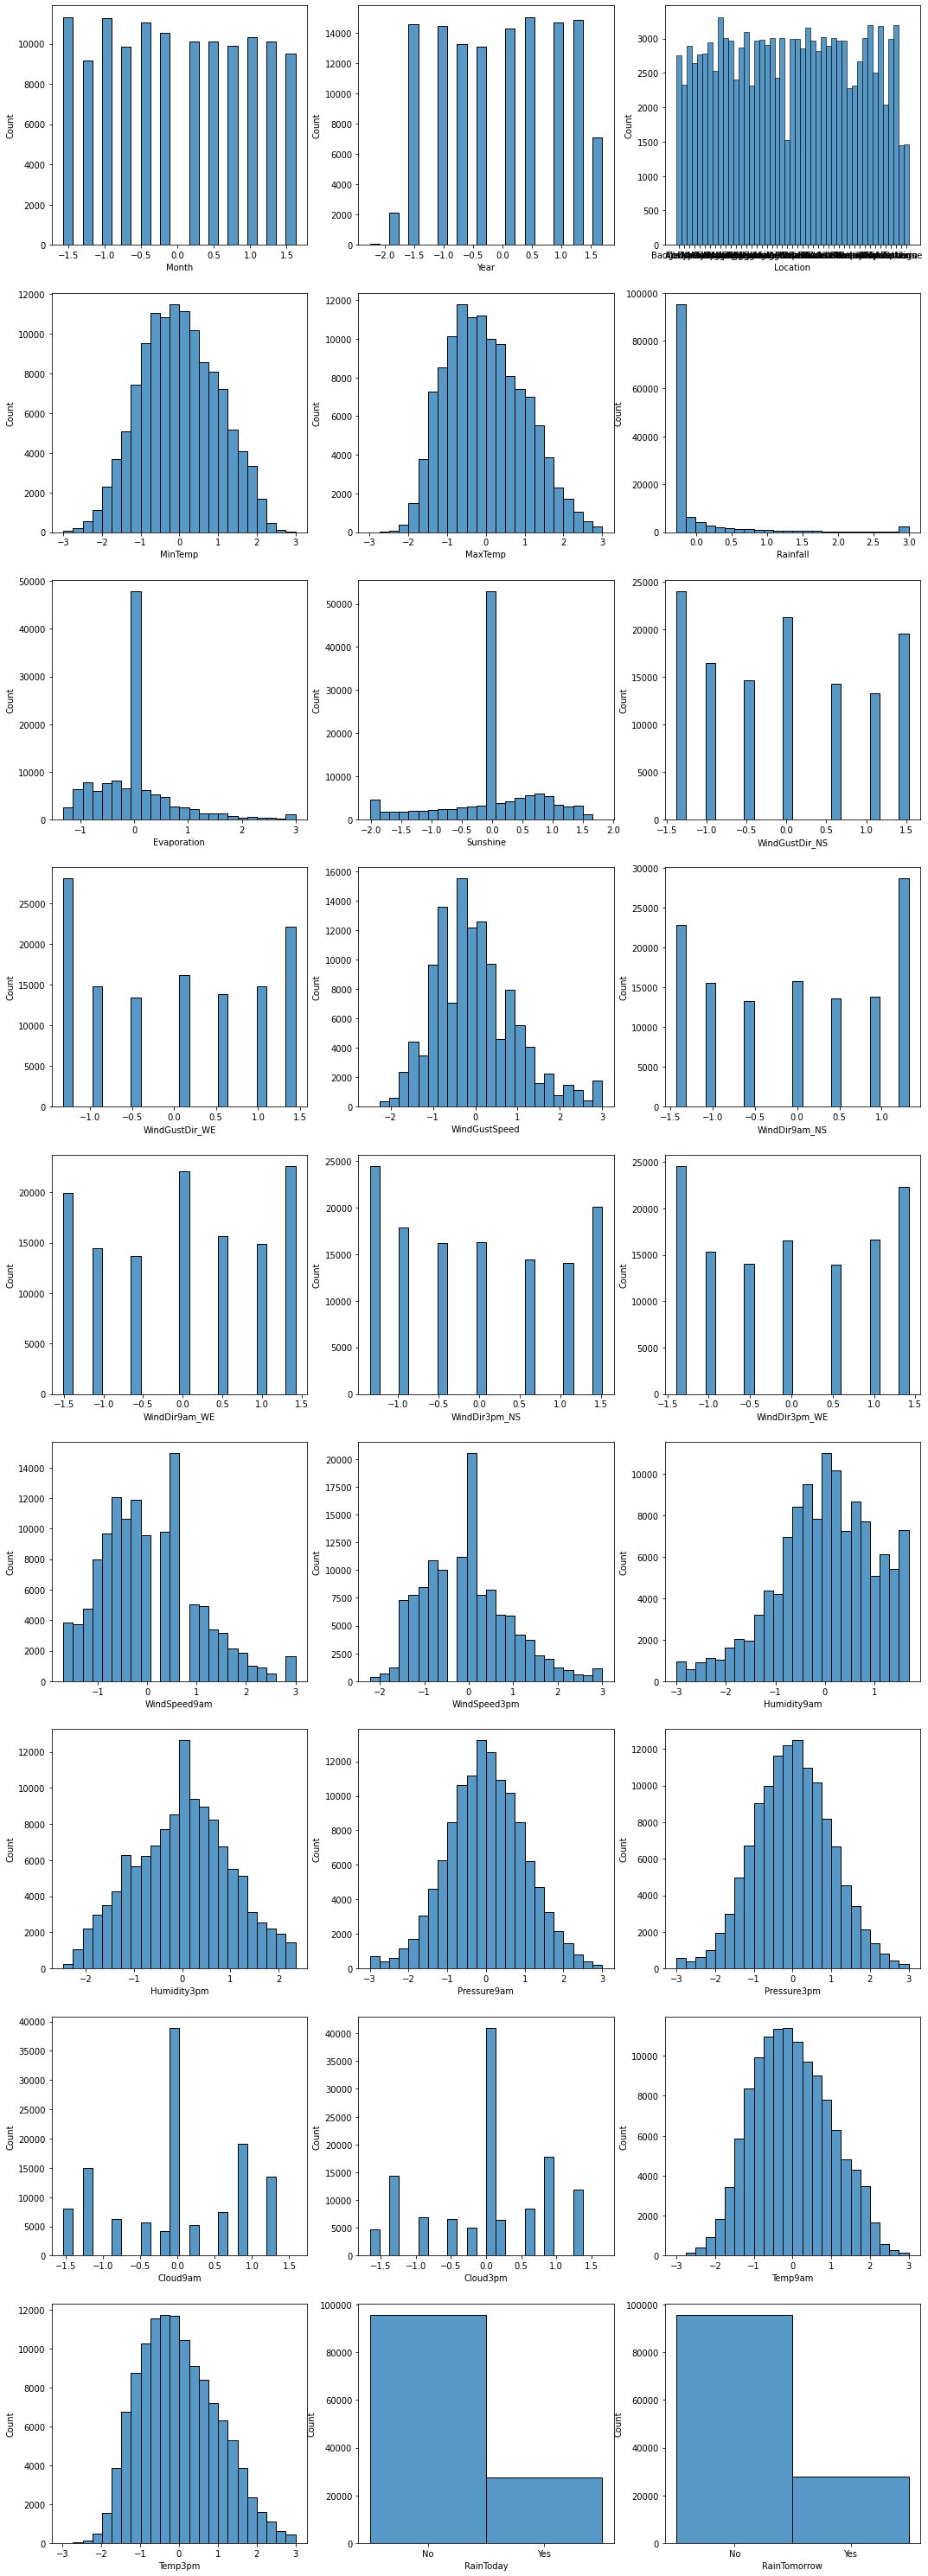

In [12]:
def plot_all_histograms(df):
    n_columns = len(df.columns)
    n_plot_cols = 3
    n_plot_rows = math.ceil(n_columns / n_plot_cols)

    fig, axs = plt.subplots(n_plot_rows, n_plot_cols, figsize=(6 * n_plot_cols, 6 * n_plot_rows))
    for idx, col_name in enumerate(df.columns):
        sns.histplot(data=df[col_name], ax=axs[idx // n_plot_cols, idx % n_plot_cols], bins=24)

    plt.show()

plot_all_histograms(df)

In [13]:
# 8.  Dummy Encode rest of the categorical columns (i.e. all except for "Date", "WindGustDir", "WindDir9am", "WindDir3pm").
cat_cols = get_cols_with_type(df, categorical=True)
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

df.head()

,Month,Year,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir_NS,WindGustDir_WE,WindGustSpeed,...,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,RainToday_Yes,RainTomorrow_Yes
0,1.622518,-1.858105,0.133575,-0.086912,-0.206660,-1.189459e-16,-2.587677e-16,0.076963,-1.318853,0.268532,...,0,0,0,0,0,0,0,0,0,0
1,1.622518,-1.858105,-0.820372,0.228285,-0.276833,-1.189459e-16,-2.587677e-16,0.633990,-1.213607,0.268532,...,0,0,0,0,0,0,0,0,0,0
2,1.622518,-1.858105,0.054079,0.314247,-0.276833,-1.189459e-16,-2.587677e-16,-0.480065,-1.213607,0.417846,...,0,0,0,0,0,0,0,0,0,0
3,1.622518,-1.858105,-0.534188,0.643772,-0.276833,-1.189459e-16,-2.587677e-16,1.106217,1.041444,-1.224607,...,0,0,0,0,0,0,0,0,0,0
4,1.622518,-1.858105,0.785438,1.259838,-0.159878,-1.189459e-16,-2.587677e-16,0.076963,-1.318853,0.044561,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# save cleaned data to a new csv file
path = Path('data', 'weatherAUS_clean.csv')
df.to_csv(path)